##**Alexandros Skondras AM: f3352119**<br>Classification of Handwritten Digits

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from numpy.linalg import svd
from numpy import linalg
import seaborn as sns
import random

In [2]:
os.getcwd()

'/content'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir(os.getcwd()+'/drive/MyDrive')

In [5]:
digits = pd.read_excel(io='data.xlsx', sheet_name='dzip', header=None)   # digits = labels
images = pd.read_excel(io='data.xlsx', sheet_name='azip', header=None)   # None--> I do not want any column labels
test_digits = pd.read_excel(io='data.xlsx', sheet_name='dtest', header=None)
test_images = pd.read_excel(io='data.xlsx', sheet_name='testzip', header=None)

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [6]:
print("Every image is represented by a 256-dims vector and there are 1707 images in total. Thus the images' matrix is of shape:",np.shape(images))

Every image is represented by a 256-dims vector and there are 1707 images in total. Thus the images' matrix is of shape: (256, 1707)


In [7]:
images      # data frame of the image vectors-->images' matrix

,0,1,2,3,4,5,6,7,8,9,...,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706
0,-1.000,-1.000,-1.000,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.0,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000
1,-1.000,-1.000,-1.000,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.0,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000
2,-1.000,-1.000,-1.000,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.0,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000
3,-1.000,-0.813,-1.000,-1.0,-1.000,-1.0,-0.830,-1.0,-1.000,-1.0,...,-1.000,-0.567,-1.000,-1.0,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000
4,-1.000,-0.671,-1.000,-1.0,-1.000,-1.0,0.442,-1.0,-1.000,-1.0,...,-0.986,-0.064,-1.000,-1.0,-1.0,-1.000,-1.0,-0.948,-1.0,-0.338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-0.991,0.126,-0.179,-1.0,0.439,-1.0,-1.000,-1.0,-0.811,-1.0,...,-1.000,-1.000,-0.633,-1.0,-1.0,-0.974,-1.0,-1.000,-1.0,-1.000
252,-1.000,-0.095,-1.000,-1.0,-0.199,-1.0,-1.000,-1.0,-1.000,-1.0,...,-1.000,-1.000,-0.782,-1.0,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000
253,-1.000,-0.671,-1.000,-1.0,-0.883,-1.0,-1.000,-1.0,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.0,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000
254,-1.000,-0.828,-1.000,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000,-1.0,...,-1.000,-1.000,-1.000,-1.0,-1.0,-1.000,-1.0,-1.000,-1.0,-1.000


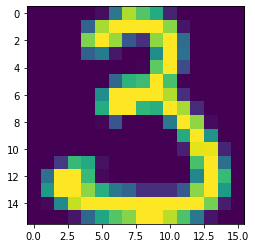

In [8]:
# The 5-th image of the data frame   /// different way --> plt.imshow(np.array(images.iloc[:,4]).reshape(16,16))
plt.imshow(images[4].to_numpy().reshape(16,16), cmap = 'viridis')

Now, the matrix of each class will be created.

In [9]:
matrix_per_class_dict = {}
for i in range(10):
  matrix_per_class_dict['A'+str(i)] = images.loc[:, digits.loc[0, :] == i]

In [10]:
# Matrix of zeros. In a similar manner the rest of the class matrices are defined.
np.shape(matrix_per_class_dict['A0'])  # --> there are in total 319 zeros in the given training data set

(256, 319)

Now, I am going to apply SVD on every class matrix.

In [11]:
Us = {}             # left singular vectors
Ss = {}             # singular values --> square roots of the positive eigenvalues
Vs = {}             # right singular vectors

for i in range(10):
  u_left, s_singular, v_right = svd(matrix_per_class_dict['A'+str(i)], full_matrices = False)
  Us['U'+str(i)] = u_left
  Ss['S'+str(i)] = s_singular
  Vs['V'+str(i)] = v_right

At this point, I will make a function to predict the class of an image using the k first singular vectors as basis for each class minimizing the norm of the residual vector of the least squares.

In [12]:
# this function gives the sum of residuals squares, so the lowest sum gives the class of the tested image
def make_prediction(k, image_to_predict, dict_of_left_singular_vectors):              # image_to_predict-->test_images
  I = np.eye(images.shape[0])
  representation_per_class_dict = {}
  for i in range(10):
    first_k_left_sing_vec = dict_of_left_singular_vectors['U'+str(i)][:, :k]
    representation_per_class_dict[i] = linalg.norm(np.dot(I-np.dot(first_k_left_sing_vec, first_k_left_sing_vec.T), image_to_predict), 2)

  return representation_per_class_dict      # in order to return the prediction right away, write instead-->
                                            # --> int(min(representation_per_class_dict, key=representation_per_class_dict.get))

For now, I choose arbitrarily to use the first 20 singular vectors to make the predictions.

In [13]:
print('So, the key, to which the minimum value of', make_prediction(20, test_images[0], Us), 'corresponds, is the class of the prediction.')

So, the key, to which the minimum value of {0: 9.450711113293485, 1: 10.895407527825512, 2: 9.569496016713455, 3: 8.69160717469732, 4: 7.2848993733497585, 5: 9.337940471185119, 6: 9.54562239560395, 7: 7.1140442777714945, 8: 8.23631827035213, 9: 3.401388165728008} corresponds, is the class of the prediction.


In [14]:
print('For example, the prediction for the 1st test image is class:', int(min(make_prediction(20, test_images[0], Us), key=make_prediction(20, test_images[0], Us).get)))

For example, the prediction for the 1st test image is class: 9


In [15]:
# the CLASS PREDICTIONS of the test_images are in the variable test_predictions
test_predictions = np.zeros(np.shape(test_images)[1])
for i in range(np.shape(test_images)[1]):
  test_predictions[i] = int(min(make_prediction(20, test_images[i], Us), key=make_prediction(20, test_images[i], Us).get))

In [16]:
test_predictions

array([9., 6., 3., ..., 4., 0., 1.])

## **Special Tasks:**

## **1)**

So, now I am going to determine (tune) how many basis vectors (between 5-20) are necessary to reach the highest accuracy. 

In [17]:
acc_of_preds_per_k = {}          #dict with items-->  k basis vectors  : accuracy percentage with k basis vectors
for i in range(5,21):
  correct_preds_count = 0
  for j in range(np.shape(test_images)[1]):
    if int(min(make_prediction(i, test_images[j], Us), key=make_prediction(i, test_images[j], Us).get)) == np.array(test_digits)[0][j]:
      correct_preds_count += 1
  acc_of_preds_per_k[i] = (correct_preds_count/np.shape(test_images)[1])*100

print(acc_of_preds_per_k)   # accuracy percentage per k first vectors

{5: 90.28400597907324, 6: 90.53313403089189, 7: 91.6791230692576, 8: 92.0279023418037, 9: 92.62580966616841, 10: 93.17389138016941, 11: 93.22371699053313, 12: 93.57249626307922, 13: 93.62232187344294, 14: 93.92127553562531, 15: 94.12057797708022, 16: 93.87144992526159, 17: 93.92127553562531, 18: 94.17040358744396, 19: 94.07075236671649, 20: 93.97110114598904}


In [18]:
print('So, the maximum accuracy percentage can be reached with', max(acc_of_preds_per_k, key=acc_of_preds_per_k.get), 'basis vectors.')

So, the maximum accuracy percentage can be reached with 18 basis vectors.


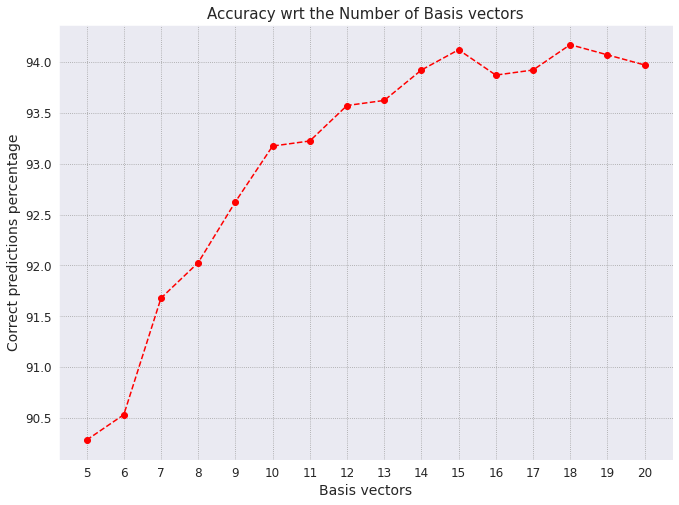

In [19]:
# use the commands in the comments to view more specific ytick values
plt.figure(figsize=(11,8))    # figsize=(11, 13)
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot(list(acc_of_preds_per_k.keys()), list(acc_of_preds_per_k.values()), marker='o', linestyle='--', color = 'r')
plt.title('Accuracy wrt the Number of Basis vectors', fontsize = 15)
plt.xlabel('Basis vectors', fontsize = 14)
plt.ylabel('Correct predictions percentage', fontsize = 14)
plt.xticks(list(acc_of_preds_per_k.keys()), fontsize = 12)
plt.yticks(fontsize = 12) # plt.yticks(list(acc_of_preds_per_k.values()), fontsize = 9)
plt.show()

## **2)**

Based on the results of the 1st specific task, I am going to use the first 18 basis vectors from this point on.

In [20]:
# images predicted correctly per class
success_per_class_dict = {}
for i in range(10):
  digit_counter = 0
  for j in range(np.shape(test_images)[1]):
    if np.array(test_digits)[0][j] == i and np.array(test_digits)[0][j] == int(min(make_prediction(18, test_images[j], Us), key=make_prediction(18, test_images[j], Us).get)):
      digit_counter += 1
  success_per_class_dict[i] = digit_counter

In [21]:
success_per_class_dict

{0: 355,
 1: 259,
 2: 178,
 3: 150,
 4: 185,
 5: 141,
 6: 163,
 7: 141,
 8: 153,
 9: 165}

In [22]:
test_digits

,0,1,2,3,4,5,6,7,8,9,...,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006
0,9,6,3,6,6,0,0,0,6,9,...,7,5,2,0,4,3,9,4,0,1


In [23]:
new_test_digits = pd.DataFrame(data = {'True_labels':test_digits.iloc[0].tolist()})

In [24]:
new_test_digits.value_counts()

True_labels
0              359
1              264
4              200
2              198
9              177
6              170
3              166
8              166
5              160
7              147
dtype: int64

In [25]:
new_test_digits.value_counts()[3]   # I am going to use this argument below 

166

In [26]:
list(success_per_class_dict.values())[3] # I am going to use this argument below 

150

In [27]:
for i in range(10):
  print('Digit class {a} has a percentage of correct predictability {b} %.'.format(a=i, b=round((list(success_per_class_dict.values())[i]/new_test_digits.value_counts()[i])*100)))

Digit class 0 has a percentage of correct predictability 99 %.
Digit class 1 has a percentage of correct predictability 98 %.
Digit class 2 has a percentage of correct predictability 90 %.
Digit class 3 has a percentage of correct predictability 90 %.
Digit class 4 has a percentage of correct predictability 92 %.
Digit class 5 has a percentage of correct predictability 88 %.
Digit class 6 has a percentage of correct predictability 96 %.
Digit class 7 has a percentage of correct predictability 96 %.
Digit class 8 has a percentage of correct predictability 92 %.
Digit class 9 has a percentage of correct predictability 93 %.


Thus, it is apparent that not all digits are equally easy to classify.<br>Now, I am going to depict some images of digit classes 5, 2 and 3, which are the most difficult ones to predict correctly.

In [28]:
# predictions for 18 basis vectors (optimal number of vectors)
test_predictions = np.zeros(np.shape(test_images)[1])
for i in range(np.shape(test_images)[1]):
  test_predictions[i] = int(min(make_prediction(18, test_images[i], Us), key=make_prediction(18, test_images[i], Us).get))

In [29]:
index_list_with_fives = new_test_digits.index[(new_test_digits.True_labels == 5) & (test_predictions != 5)].tolist()   # indices of images with misclassified 5s
index_list_with_twos = new_test_digits.index[(new_test_digits.True_labels == 2) & (test_predictions != 2)].tolist()    # indices of images with misclassified 2s
index_list_with_threes = new_test_digits.index[(new_test_digits.True_labels == 3) & (test_predictions != 3)].tolist()  # indices of images with misclassified 5s

random.seed(2)

# I choose 3 misclassified images from each class (5,2,3)
random_3_fives = random.choices(index_list_with_fives, k=3)
random_3_twos = random.choices(index_list_with_twos, k=3)
random_3_threes = random.choices(index_list_with_threes, k=3)

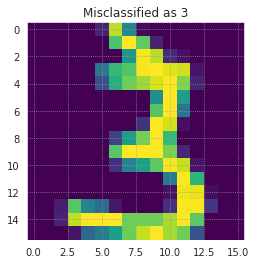

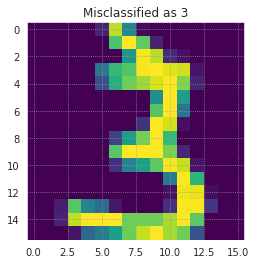

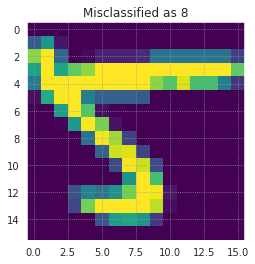

In [30]:
# show misclassified pictures of the most difficult digit classes to predict
for i in random_3_fives:
  plt.imshow(test_images[i].to_numpy().reshape(16,16), cmap = 'viridis')
  plt.title(f'Misclassified as {int(test_predictions[i])}')
  plt.show()

Here, it is obvious that the 3rd picture does not really look like the number 3.

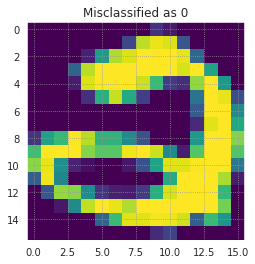

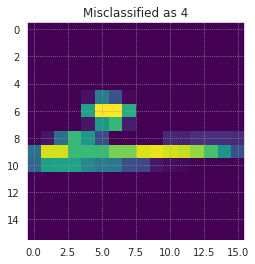

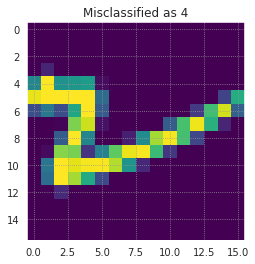

In [31]:
for i in random_3_twos:
  plt.imshow(test_images[i].to_numpy().reshape(16,16), cmap = 'viridis')
  plt.title(f'Misclassified as {int(test_predictions[i])}')
  plt.show()

In this case, it is apparent that the first picture (maybe even the other pictures as well) does not look like the number 2.

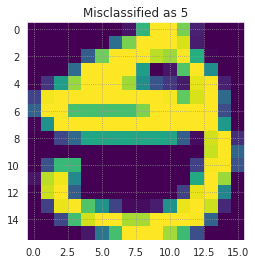

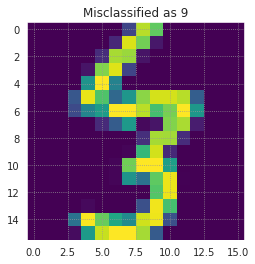

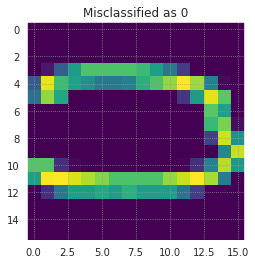

In [32]:
for i in random_3_threes:
  plt.imshow(test_images[i].to_numpy().reshape(16,16), cmap = 'viridis')
  plt.title(f'Misclassified as {int(test_predictions[i])}')
  plt.show()

The 1st and the 3rd picture are clearly really badly written. They most definitely do not look like the depict the number 3.

## **3)**

Distribution per Digit Class from the 1st-20th Singular Value:

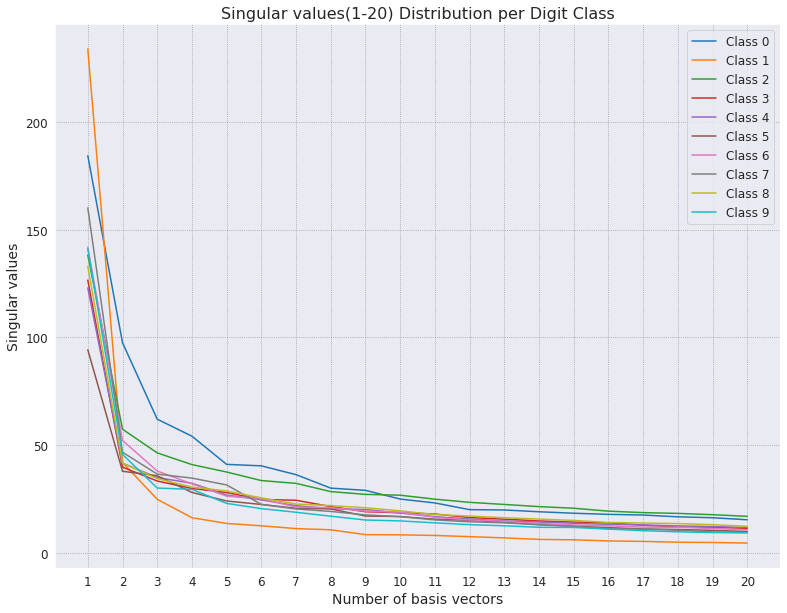

In [33]:
plt.figure(figsize=(13,10))
plt.title('Singular values(1-20) Distribution per Digit Class', fontsize = 16)
plt.xlabel('Number of basis vectors', fontsize = 14)
plt.ylabel('Singular values', fontsize = 14)

for i in range(10):
  plt.plot([k for k in range(1, 21)], [Ss['S'+str(i)][j] for j in range(20)], linestyle='-', label='Class '+str(i))  # (5,    (4, 

plt.xticks([k for k in range(1, 21)], fontsize = 12)   # (5,
plt.yticks(fontsize = 12)
plt.legend(loc="upper right", fontsize = 12)

plt.show()

Distribution per Digit Class from the 5th-20th Singular Value to have a better zoomed depiction:

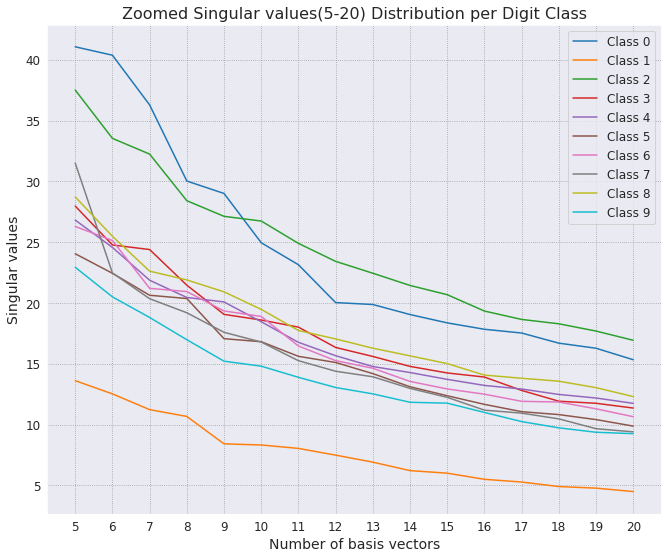

In [34]:
plt.figure(figsize=(11,9))
plt.title('Zoomed Singular values(5-20) Distribution per Digit Class', fontsize = 16)
plt.xlabel('Number of basis vectors', fontsize = 14)
plt.ylabel('Singular values', fontsize = 14)

for i in range(10):
  plt.plot([k for k in range(5, 21)], [Ss['S'+str(i)][j] for j in range(4, 20)], linestyle='-', label='Class '+str(i))

plt.xticks([k for k in range(5, 21)], fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(loc="upper right", fontsize = 12)

plt.show()

So, it seems that the Digit Classes 0 and 2 have higher singular values (from the 5th-20th). These value differences start to deteriorate as we move from the first few (5th-10th) singular values towards the 20th one. Considering, though, that the importance of the Singular Value Decomposition lies to each goal, which is to reduce a dataset containing a large number of values to a dataset containing significantly fewer values, that preserve a large fraction of the variability contained in the original data, one could come to the conclusion that for Digit Class 1 (orange color line), it could potentially suffice to use fewer basis vectors in order to get correct predictions with accuracy as high as if more basis vectors were used.<br>(a large singular value as an intuitive measure of great significance of the respective basis vector-->the larger the singular value, the more the variability/information it carries in the linear transformation)

For example, based on the graph, I am going to calculate the accuracy percentage using indicatively different number of basis vectors.

In [35]:
# images predicted correctly per class
success_per_class_dict_7_basis_vectors = {}
for i in range(10):
  digit_counter = 0
  for j in range(np.shape(test_images)[1]):
    if np.array(test_digits)[0][j] == i and np.array(test_digits)[0][j] == int(min(make_prediction(7, test_images[j], Us), key=make_prediction(7, test_images[j], Us).get)):
      digit_counter += 1
  success_per_class_dict_7_basis_vectors[i] = digit_counter

Accuracy percentages per Digit Class using 7 basis vectors:

In [36]:
for i in range(10):
  print('Digit class {a} has a percentage of correct predictability {b} %.'.format(a=i, b=round((list(success_per_class_dict_7_basis_vectors.values())[i]/new_test_digits.value_counts()[i])*100)))

Digit class 0 has a percentage of correct predictability 98 %.
Digit class 1 has a percentage of correct predictability 98 %.
Digit class 2 has a percentage of correct predictability 90 %.
Digit class 3 has a percentage of correct predictability 87 %.
Digit class 4 has a percentage of correct predictability 86 %.
Digit class 5 has a percentage of correct predictability 84 %.
Digit class 6 has a percentage of correct predictability 94 %.
Digit class 7 has a percentage of correct predictability 94 %.
Digit class 8 has a percentage of correct predictability 84 %.
Digit class 9 has a percentage of correct predictability 92 %.


In [37]:
# images predicted correctly per class
success_per_class_dict_9_basis_vectors = {}
for i in range(10):
  digit_counter = 0
  for j in range(np.shape(test_images)[1]):
    if np.array(test_digits)[0][j] == i and np.array(test_digits)[0][j] == int(min(make_prediction(9, test_images[j], Us), key=make_prediction(9, test_images[j], Us).get)):
      digit_counter += 1
  success_per_class_dict_9_basis_vectors[i] = digit_counter

Accuracy percentages per Digit Class using 9 basis vectors:

In [38]:
for i in range(10):
  print('Digit class {a} has a percentage of correct predictability {b} %.'.format(a=i, b=round((list(success_per_class_dict_9_basis_vectors.values())[i]/new_test_digits.value_counts()[i])*100)))

Digit class 0 has a percentage of correct predictability 99 %.
Digit class 1 has a percentage of correct predictability 99 %.
Digit class 2 has a percentage of correct predictability 90 %.
Digit class 3 has a percentage of correct predictability 89 %.
Digit class 4 has a percentage of correct predictability 91 %.
Digit class 5 has a percentage of correct predictability 86 %.
Digit class 6 has a percentage of correct predictability 94 %.
Digit class 7 has a percentage of correct predictability 95 %.
Digit class 8 has a percentage of correct predictability 86 %.
Digit class 9 has a percentage of correct predictability 89 %.


Accuracy percentages per Digit Class using 18 basis vectors to make a comparison:

In [39]:
for i in range(10):
  print('Digit class {a} has a percentage of correct predictability {b} %.'.format(a=i, b=round((list(success_per_class_dict.values())[i]/new_test_digits.value_counts()[i])*100)))

Digit class 0 has a percentage of correct predictability 99 %.
Digit class 1 has a percentage of correct predictability 98 %.
Digit class 2 has a percentage of correct predictability 90 %.
Digit class 3 has a percentage of correct predictability 90 %.
Digit class 4 has a percentage of correct predictability 92 %.
Digit class 5 has a percentage of correct predictability 88 %.
Digit class 6 has a percentage of correct predictability 96 %.
Digit class 7 has a percentage of correct predictability 96 %.
Digit class 8 has a percentage of correct predictability 92 %.
Digit class 9 has a percentage of correct predictability 93 %.


Based on the accuracy percentages results, it is confirmed that Class 1 does not need 18 basis vectors to in order to be predicted, but fewer suffice (for example 7 basis vectors).<br> Notice, though, that Classes 0 and 2, whose curves are on top of the Zoomed graph(5-20), indicate a similar accuracy percentage (if not the same) in all 3 cases tested, for 7, 9 and 18 basis vectors. This can be justified by the fact that in the (1-20) graph, their plots start from very high up (as does Class 1). This means that in their first singular values(roughly 1-5), a really big/significant percentage of their total variability/information is carried, such that their correct predictability remains as easily feasible.

Comment: The fact that Digit Class 1 does not seem to carry as much information as the other classes and does not seem to demand as many basis vectors to achieve high accuracy percentages, might have to do with the visual nature of number 1 (in comparison also to the other numbers), which is more or less just a straight line.